In [196]:
!pip install pydub
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython

In [197]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os
from pydub import AudioSegment

# Calculate and plot spectrogram for a wav audio file
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

# Load a wav file
def get_wav_info(wav_file):
    rate, data = wavfile.read(wav_file)
    return rate, data

# Used to standardize volume of audio clip
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

# Load raw audio files for speech synthesis
def load_raw_audio():
    activates = []
    backgrounds = []
    negatives = []
    for filename in os.listdir("/kaggle/input/trigger/Positive/Positive/"):
        if filename.endswith("wav"):
            activate = AudioSegment.from_wav("/kaggle/input/trigger/Positive/Positive/"+filename)
            activates.append(activate)
    for filename in os.listdir("/kaggle/input/trigger/Noise/Noise/"):
        if filename.endswith("wav"):
            background = AudioSegment.from_wav("/kaggle/input/trigger/Noise/Noise/"+filename)
            backgrounds.append(background)
    for filename in os.listdir("/kaggle/input/trigger/Negative/Negative/"):
        if filename.endswith("wav"):
            negative = AudioSegment.from_wav("/kaggle/input/trigger/Negative/Negative/"+filename)
            negatives.append(negative)
    return activates, negatives, backgrounds

In [198]:
Tx = 5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

In [199]:
Ty = 1375 # The number of time steps in the output of our model

In [200]:
activates, negatives, backgrounds = load_raw_audio()

In [201]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

In [202]:
def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    segment_start, segment_end = segment_time
    
    ### START CODE HERE ### (≈ 4 line)
    # Step 1: Initialize overlap as a "False" flag. (≈ 1 line)
    overlap = False
    
    # Step 2: loop over the previous_segments start and end times.
    # Compare start/end times and set the flag to True if there is an overlap (≈ 3 lines)
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True
    ### END CODE HERE ###

    return overlap

In [203]:
def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    ### START CODE HERE ### 
    # Step 1: Use one of the helper functions to pick a random time segment onto which to insert 
    # the new audio clip. (≈ 1 line)
    segment_time = get_random_time_segment(segment_ms)
    
    # Step 2: Check if the new segment_time overlaps with one of the previous_segments. If so, keep 
    # picking new segment_time at random until it doesn't overlap. (≈ 2 lines)
    while is_overlapping(segment_time, previous_segments):
        segment_time = get_random_time_segment(segment_ms)

    # Step 3: Add the new segment_time to the list of previous_segments (≈ 1 line)
    previous_segments.append(segment_time)
    ### END CODE HERE ###
    
    # Step 4: Superpose audio segment and background
    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

In [204]:
def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 followinf labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    # Add 1 to the correct index in the background label (y)
    ### START CODE HERE ### (≈ 3 lines)
    for i in range(segment_end_y + 1, segment_end_y + 51):
        if i < Ty:
            y[0, i] = 1
    ### END CODE HERE ###
    
    return y

In [205]:
def create_training_example(background, activates, negatives):
    """
    Creates a training example with a given background, activates, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    activates -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    
    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    
    # Set the random seed
   
    
    # Make background quieter
    background = background - 20

    ### START CODE HERE ###
    # Step 1: Initialize y (label vector) of zeros (≈ 1 line)
    y = np.zeros((1, Ty))

    # Step 2: Initialize segment times as empty list (≈ 1 line)
    previous_segments = []
    ### END CODE HERE ###
    
    # Select 0-4 random "activate" audio clips from the entire list of "activates" recordings
    number_of_activates = np.random.randint(0, 5)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]
    
    ### START CODE HERE ### (≈ 3 lines)
    # Step 3: Loop over randomly selected "activate" clips and insert in background
    for random_activate in random_activates:
        # Insert the audio clip on the background
        background, segment_time = insert_audio_clip(background, random_activate, previous_segments)
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y"
        y = insert_ones(y, segment_end_ms=segment_end)
    ### END CODE HERE ###

    # Select 0-2 random negatives audio recordings from the entire list of "negatives" recordings
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    ### START CODE HERE ### (≈ 2 lines)
    # Step 4: Loop over randomly selected negative clips and insert in background
    for random_negative in random_negatives:
        # Insert the audio clip on the background 
        background, _ = insert_audio_clip(background, random_negative, previous_segments)
    ### END CODE HERE ###
    
    # Standardize the volume of the audio clip 
    background = match_target_amplitude(background, -20.0)

    # Export new training example 
    file_handle = background.export("train" + ".wav", format="wav")
    print("File (train.wav) was saved in your directory.")
    
    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    x = graph_spectrogram("train.wav")
    print(y)
    return x, y

File (train.wav) was saved in your directory.
[[0. 0. 0. ... 0. 0. 0.]]
File (train.wav) was saved in your directory.
[[0. 0. 0. ... 0. 0. 0.]]
File (train.wav) was saved in your directory.
[[0. 0. 0. ... 0. 0. 0.]]
File (train.wav) was saved in your directory.
[[0. 0. 0. ... 0. 0. 0.]]
File (train.wav) was saved in your directory.
[[0. 0. 0. ... 0. 0. 0.]]
File (train.wav) was saved in your directory.
[[0. 0. 0. ... 0. 0. 0.]]
File (train.wav) was saved in your directory.
[[0. 0. 0. ... 0. 0. 0.]]
File (train.wav) was saved in your directory.
[[0. 0. 0. ... 1. 1. 1.]]
File (train.wav) was saved in your directory.
[[0. 0. 0. ... 0. 0. 0.]]
File (train.wav) was saved in your directory.
[[0. 0. 0. ... 0. 0. 0.]]
File (train.wav) was saved in your directory.
[[0. 0. 0. ... 0. 0. 0.]]
File (train.wav) was saved in your directory.
[[0. 0. 0. ... 0. 0. 0.]]
File (train.wav) was saved in your directory.
[[0. 0. 0. ... 0. 0. 0.]]
File (train.wav) was saved in your directory.
[[0. 0. 0. ... 0. 

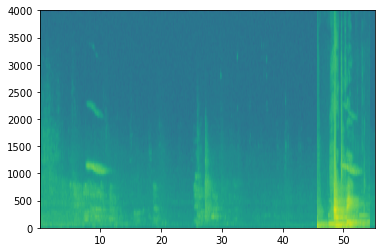

In [206]:
X=[]
Y=[]
for i in range(0,13):
    x, y = create_training_example(backgrounds[0], activates, negatives)
    X.append(x)
    Y.append(y)
for i in range(13,26):
    x, y = create_training_example(backgrounds[1], activates, negatives)
    X.append(x)
    Y.append(y)

In [207]:
X=np.array([X])
X=X[0]
Y=np.array([Y])
Y=Y[0]

In [208]:
print(X.shape)
print(Y.shape)

(26, 101, 5511)
(26, 1, 1375)


In [209]:
X=np.transpose(X,(0,2,1))
Y=np.transpose(Y,(0,2,1))

In [210]:
print(X.shape)
print(Y.shape)

(26, 5511, 101)
(26, 1375, 1)


In [211]:
print(X)

[[[2.20865699e-03 3.56328051e-03 1.86543358e-03 ... 2.40832552e-05
   3.46631234e-05 1.99747622e-05]
  [4.25204347e-01 3.02224293e-01 4.31903119e-01 ... 4.95312959e-05
   2.30706309e-05 9.38072609e-05]
  [5.56107571e+01 6.55553835e+01 6.61958300e+01 ... 3.34265181e-05
   5.04719614e-05 6.61220451e-05]
  ...
  [4.65021057e-02 1.92675034e-02 2.21130027e-02 ... 1.93205575e-05
   5.25236014e-05 6.27861382e-05]
  [1.51422866e-02 4.26564236e-03 9.48519335e-03 ... 1.14700912e-06
   2.57628809e-05 2.34578988e-07]
  [6.36612234e-02 5.85119230e-02 3.65978625e-03 ... 2.03634530e-05
   1.06622700e-04 8.82449760e-05]]

 [[9.82181585e-04 1.58384281e-03 8.28389265e-04 ... 1.06245985e-05
   1.53990417e-05 8.93064295e-06]
  [2.07816057e-01 1.53897532e-01 2.13824970e-01 ... 1.26035751e-05
   2.01900895e-05 6.36305536e-05]
  [2.77318522e+01 3.26950622e+01 3.29452644e+01 ... 2.57672444e-05
   4.36161271e-05 4.78402199e-05]
  ...
  [2.06676025e-02 8.56333483e-03 9.82800120e-03 ... 8.58691443e-06
   2.33438

In [212]:
print(Y)

[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [1.]
  [1.]
  [1.]]]


In [213]:
for i in Y[0]:
    print(i)

[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]


In [214]:
#from sklearn.model_selection import train_test_split
#X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=37)

In [215]:
#X_train.shape

In [216]:
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

In [221]:
def model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    ### START CODE HERE ###
    
    # Step 1: CONV layer (≈4 lines)
    X = Conv1D(196, kernel_size=15, strides=4)(X_input)                                 # CONV1D
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Activation('relu')(X)                                 # ReLu activation
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)

    # Step 2: First GRU Layer (≈4 lines)
    X = GRU(units = 128, return_sequences = True)(X) # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                                 # Batch normalization
    
    # Step 3: Second GRU Layer (≈4 lines)
    X = GRU(units = 128, return_sequences = True)(X)   # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                                  # Batch normalization
    X = Dropout(0.8)(X)                                  # dropout (use 0.8)
    
    # Step 4: Time-distributed dense layer (≈1 line)
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)

    ### END CODE HERE ###

    model = Model(inputs = X_input, outputs = X)
    
    return model


In [222]:
model = model(input_shape = (Tx, n_freq))

In [219]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 5511, 101)         0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1375, 196)         297136    
_________________________________________________________________
batch_normalization_13 (Batc (None, 1375, 196)         784       
_________________________________________________________________
activation_5 (Activation)    (None, 1375, 196)         0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 1375, 196)         0         
_________________________________________________________________
gru_9 (GRU)                  (None, 1375, 128)         124800    
_________________________________________________________________
dropout_18 (Dropout)         (None, 1375, 128)         0   

In [223]:

model = load_model("/kaggle/input/models/tr_model.h5")


/opt/conda/lib/python3.7/site-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [224]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])


In [226]:
model.fit(X,Y,batch_size=10,epochs=1)

Epoch 1/1
26/26 [==============================] - 13s 493ms/step - loss: 0.0968 - accuracy: 0.9634


In [ ]:
#from keras.models import model_from_json
#model.save_weights("model.h5")
#print("Saved model to disk")

In [227]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)

    x = graph_spectrogram(filename)
    # the spectogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

In [228]:
chime_file = "/kaggle/input/audio-files/chime.wav"
def chime_on_activate(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    # Step 2: Loop over the output steps in the y
    for i in range(Ty):
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        # Step 4: If prediction is higher than the threshold and more than 75 consecutive output steps have passed
        if predictions[0,i,0] > threshold and consecutive_timesteps > 30:
            # Step 5: Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            # Step 6: Reset consecutive output steps to 0
            consecutive_timesteps = 0
        
    audio_clip.export("chime_output.wav", format='wav')

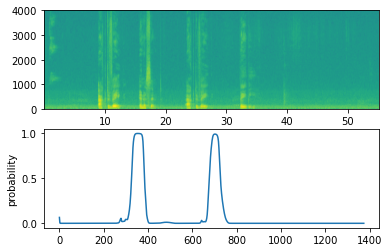

In [229]:
filename = "/kaggle/input/audio-files/2.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.3)
IPython.display.Audio("./chime_output.wav")

In [ ]:
def preprocess_audio(filename):
    # Trim or pad audio segment to 10000ms
    padding = AudioSegment.silent(duration=10000)
    segment = AudioSegment.from_wav(filename)[:10000]
    segment = padding.overlay(segment)
    # Set frame rate to 44100
    segment = segment.set_frame_rate(44100)
    # Export as wav
    segment.export(filename, format='wav')

In [ ]:
your_filename = "audio_examples/my_audio.wav"

In [ ]:
chime_threshold = 0.5
prediction = detect_triggerword(your_filename)
chime_on_activate(your_filename, prediction, chime_threshold)
IPython.display.Audio("./chime_output.wav")